In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
%matplotlib inline
import numpy as np
from scipy.integrate import odeint
import math
import matplotlib.pyplot as plt
from matplotlib import rcParams

plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})

π = np.pi
Ω_cdm = 0.85
G = 6.67e-11                # in units of m^3⋅kg^−1⋅s^−2
t_i = 2.358e5                # in units of seconds
t_eq = 1.5923e12            # in units of seconds
ρ_eq = 2.1548e-16          # in units of kg m^-3
M_solar = 1.989e30        # in units of kg
c = 3e8                 #in units of m/s
A = 1.495e11                 # Astronomical unit
pc = 3.085e16               # in unist of meter. 
yr = 3.154e7              # in units of seconds
a_eq = 2.9374e-4

hbar = 1.0545718e-34        # reduced Planck constant in unkits of J.s
eV = 1.60218e-19               #in units of J
eV_to_kg = 1.7826e-36             #in units of kg
m_FDM_eV = 1e-22     #in units of eV/c²
m_FDM = m_FDM_eV * eV_to_kg      # Mass of FDM boson in units of kg


h = 0.67
ρ_c0= 1.9e-26 * (h**2) #kgm^-3  
Ω_r0 = 9.4e-5
Ω_m0 = 0.32
ρ_r0 = Ω_r0 * ρ_c0
ρ_m0 = Ω_m0 * ρ_c0
H_0 = np.sqrt((8 * π * G * ρ_c0)/3)




# Define event functions to detect turnaround points
def event_y_max(t, y, *args):
    return y[1]  # Detect velocity = 0 (turnaround)
event_y_max.terminal = False  
event_y_max.direction = -1  # Detect peak (expansion slowing down)



def event_y_min(t, y, *args):
    return y[1]  # Detect velocity = 0
event_y_min.terminal = True   # Stop at turnaround
event_y_min.direction = 1     # Detect minimum (collapse starts)



#def a(t): # as per RD
    #return np.sqrt(2 * H_0 * t)
    
#def rho_DM(t):
    #return 0.85 * ρ_m0 * (a(t)**-3)  

    
def a(t):
    return  np.sqrt(2 * t * (a_eq**2))  *  ((3/(4 * π * G * ρ_eq))**(-1/2))


def V_shell(r_outer, r_inner):
    return (4 * π / 3) * (r_outer**3 - r_inner**3)


def rho_DM(t):
    return (ρ_eq/2) * ((a(t)/a_eq)**(-3))  


def mfdm_shell_initial(r, t):
    return rho_DM(t) * ((4/3) * np.pi * (r**3)) 


def fdm_EOM(t, y, j):
    r, v = y 
    #print(delta_M[0])
    M_enclosed_total = M_pbh #+  np.sum(delta_M[:j+1])  
    dv_G_dt = -(G * M_enclosed_total)/(r**2)  # G.P.due to PBH only
    dv_QP_dt = QP_arr[j] 
    H_t = 1/(2*t)  # with H(t) = 1/2t in RD
    dv_H_dt = -(H_t*v)  #-ri_arr[j]/(4 * (t**2)) 
    return [v, dv_G_dt + dv_QP_dt + dv_H_dt]

In [4]:
#Trying solving the simultaneous dynamics of all the shells without QP term. 
# Setting the correct evaluation of the volume of the first shell and 
# the evaluation of the QP term for the whole r_sol array. 



t_i, t_f = 1e-15, 1e20
r_min, r_max = 1e-8, 1e-4
N = 7


ri_arr = np.geomspace(r_min, r_max, N)
t_arr = np.geomspace(t_i, t_f, 3)
dt = np.gradient(t_arr)


def V_shell(r_outer, r_inner):
    if (r_outer - r_inner) <= 1e-15: #or np.isclose(r_outer, r_inner, rtol=1e-9, atol=1e-12):
        return 1e-15
    else:
        return (4/3) * np.pi * (r_outer**3 - r_inner**3)


initial_density = 1e-20
delta_M_arr = np.zeros(N)
for j in range(N):
    rho_arr = np.full(N, initial_density)
    if j == 0:
        delta_M_arr[j] = initial_density * V_shell(ri_arr[j], 0)
    else:
        delta_M_arr[j] = initial_density * V_shell(ri_arr[j], ri_arr[j-1])


r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr / (2 * t_i)


turnaround_detected = np.zeros(N, dtype=bool)
t_ta_arr = np.zeros(N)
r_ta_arr = np.zeros(N)


for i in range(len(t_arr) - 1):
    t = t_arr[i]
    dt_i = dt[i]
    rho_arr = np.zeros(N)  

    for j in range(N-1):
        if j == 0:
            delta_V = V_shell(r_sol[1, i], r_sol[0, i])
            if delta_V > 0:
                rho_arr[j] =  (delta_M_arr[1] + delta_M_arr[0])/delta_V
            else:
                rho_arr[j] = rho_sol[j, i-1] 
        else:
            delta_Vj = V_shell(r_sol[j, i], r_sol[j-1, i]) 
            delta_Vj1 = V_shell(r_sol[j+1, i], r_sol[j, i])
            delta_Vsum = delta_Vj + delta_Vj1
            if delta_Vsum > 0:
                rho_arr[j] = (delta_M_arr[j] + delta_M_arr[j+1])/delta_Vsum
            else:
                rho_arr[j] = rho_sol[j, i-1]  
    
    delta_V_last = V_shell(r_sol[-1, i], r_sol[-2, i])
    rho_arr[-1] =  delta_M_arr[-1]/delta_V_last if delta_V_last>0 else rho_sol[-1, i-1]
    rho_sol[:, i] = rho_arr 
    print(rho_arr)
    grad_rho = np.gradient(rho_arr, r_sol[:, i], edge_order=2)
    laplacian_rho = (1 / (r_sol[:, i]**2)) * np.gradient((r_sol[:, i]**2) * grad_rho, r_sol[:, i], edge_order=2)
    qp_term = (laplacian_rho / rho_arr) - (0.5 * (grad_rho**2) / (rho_arr**2))
    QP_arr = (1/4) * np.gradient(qp_term, r_sol[:, i], edge_order=2)[j]
    for j in range(N):
        dv_G_dt = -1 / (r_sol[j, i]**2) if r_sol[j, i] > 0 else 0
        dv_QP_dt = QP_arr
        dv_H_dt = -r_sol[j, i] / (4 * (t**2))
        dv_dt = dv_G_dt + dv_H_dt + dv_QP_dt

        v_sol[j, i+1] = v_sol[j, i] + dv_dt * dt_i
        r_sol[j, i+1] = r_sol[j, i] + v_sol[j, i] * dt_i
        if not turnaround_detected[j]:
            if v_sol[j, i] > 0 and v_sol[j, i+1] < 0:
                turnaround_detected[j] = True
                t_ta_arr[j] = t_arr[i+1]
                r_ta_arr[j] = r_sol[j, i+1]
        elif t_arr[i] >= t_ta_arr[j]:
            if i + 1 < len(t_arr):
                v_sol[j, i+1] = v_sol[j, i] + dv_dt * dt_i
                r_sol[j, i+1] = r_sol[j, i] + v_sol[j, i] * dt_i


[1.01010101e-20 1.00000000e-20 1.00000000e-20 1.00000000e-20
 1.00000000e-20 1.00000000e-20 1.00000000e-20]
[2.55537589e-72 2.52982213e-72 2.52982213e-72 2.52982213e-72
 2.52982213e-72 2.52982213e-72 2.52982213e-72]


/home/pratibhajangra/miniconda3/envs/PhD/lib/python3.9/site-packages/numpy/lib/function_base.py:1211: RuntimeWarning: divide by zero encountered in true_divide
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
/home/pratibhajangra/miniconda3/envs/PhD/lib/python3.9/site-packages/numpy/lib/function_base.py:1248: RuntimeWarning: divide by zero encountered in double_scalars
  a = -1.5 / ax_dx
/home/pratibhajangra/miniconda3/envs/PhD/lib/python3.9/site-packages/numpy/lib/function_base.py:1249: RuntimeWarning: divide by zero encountered in double_scalars
  b = 2. / ax_dx
/home/pratibhajangra/miniconda3/envs/PhD/lib/python3.9/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: divide by zero encountered in double_scalars
  c = -0.5 / ax_dx
/home/pratibhajangra/miniconda3/envs/PhD/lib/python3.9/site-packages/numpy/lib/function_base.py:1258: RuntimeWarning: invalid value encountered in double_scalars
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(

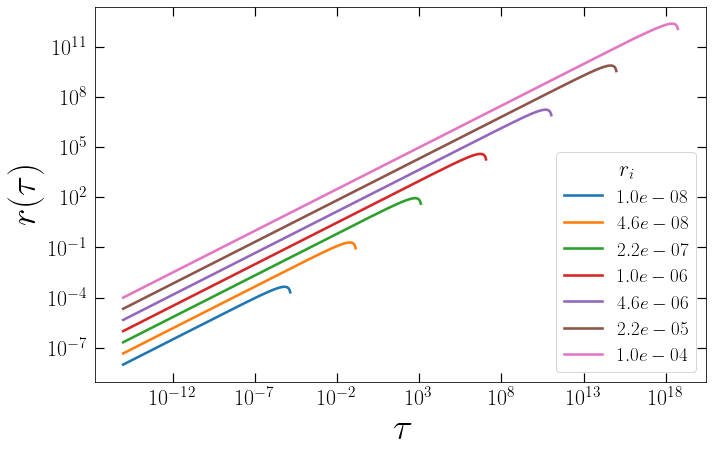

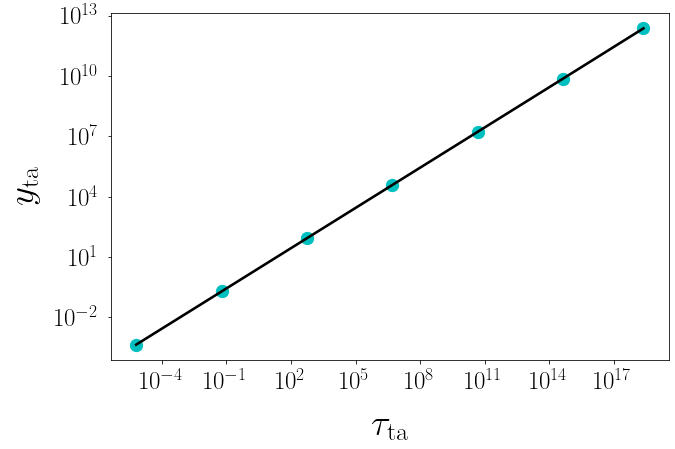

y_ta_arr = [4.45616387e-04 1.97693119e-01 8.74519484e+01 3.85616230e+04
 1.69593790e+07 7.35088466e+09 2.33299789e+12]


tau_ta_arr = [6.37500380e-06 5.98932304e-02 5.53699750e+02 5.11883248e+06
 4.73224811e+10 4.27034582e+14 2.35687871e+18]


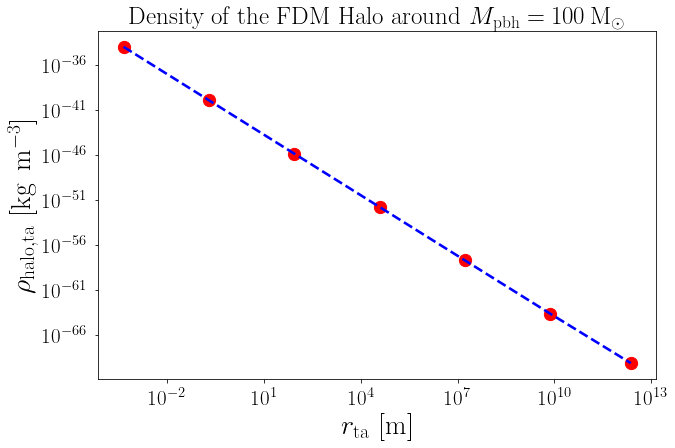

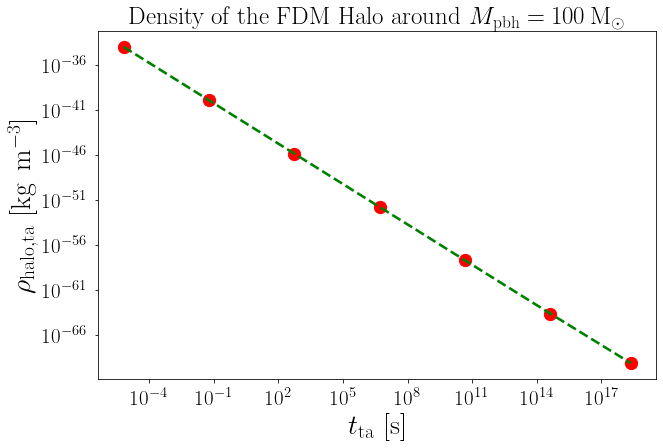

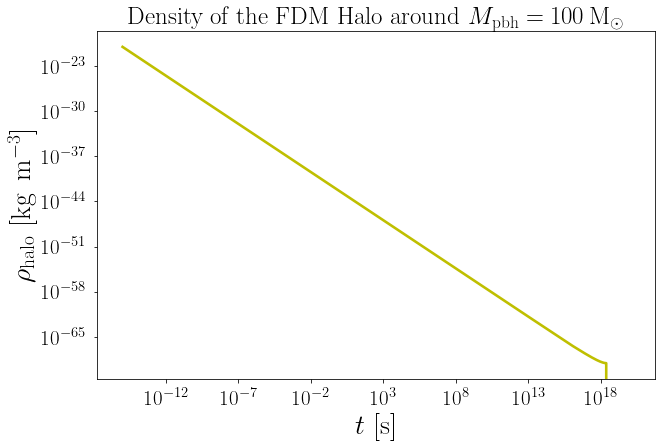

In [5]:
#Trying solving the simultaneous dynamics of all the shells without QP term. 
# Setting the correct evaluation of the volume of the first shell and 
# the evaluation of the QP term for the whole r_sol array. 



t_i, t_f = 1e-15, 1e20
r_min, r_max = 1e-8, 1e-4
N = 7


ri_arr = np.geomspace(r_min, r_max, N)
t_arr = np.geomspace(t_i, t_f, 10000)
dt = np.gradient(t_arr)


def V_shell(r_outer, r_inner):
    if (r_outer - r_inner) <= 1e-20: #or np.isclose(r_outer, r_inner, rtol=1e-9, atol=1e-12):
        return 1e-15
    else:
        return (4/3) * np.pi * (r_outer**3 - r_inner**3)


initial_density = 1e-20
delta_M_arr = np.zeros(N)
for j in range(N):
    rho_arr = np.full(N, initial_density)
    if j == 0:
        delta_M_arr[j] = initial_density * V_shell(ri_arr[j], 0)
    else:
        delta_M_arr[j] = initial_density * V_shell(ri_arr[j], ri_arr[j-1])


r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr / (2 * t_i)


turnaround_detected = np.zeros(N, dtype=bool)
t_ta_arr = np.zeros(N)
r_ta_arr = np.zeros(N)


for i in range(len(t_arr) - 1):
    t = t_arr[i]
    dt_i = dt[i]
    rho_arr = np.zeros(N)  

    for j in range(N-1):
        if j == 0:
            delta_V = V_shell(r_sol[1, i], r_sol[0, i])
            if delta_V > 0:
                rho_arr[j] =  (delta_M_arr[1] + delta_M_arr[0])/delta_V
            else:
                rho_arr[j] = rho_sol[j, i-1] 
        else:
            delta_Vj = V_shell(r_sol[j, i], r_sol[j-1, i]) 
            delta_Vj1 = V_shell(r_sol[j+1, i], r_sol[j, i])
            delta_Vsum = delta_Vj + delta_Vj1
            if delta_Vsum > 0:
                rho_arr[j] = (delta_M_arr[j] + delta_M_arr[j+1])/delta_Vsum
            else:
                rho_arr[j] = rho_sol[j, i-1]  
    
    delta_V_last = V_shell(r_sol[-1, i], r_sol[-2, i])
    rho_arr[-1] =  delta_M_arr[-1]/delta_V_last if delta_V_last>0 else rho_sol[-1, i-1]
    rho_sol[:, i] = rho_arr 
    #print(rho_arr)
    grad_rho = np.gradient(rho_arr, r_sol[:, i], edge_order=2)
    laplacian_rho = (1 / (r_sol[:, i]**2)) * np.gradient((r_sol[:, i]**2) * grad_rho, r_sol[:, i], edge_order=2)
    qp_term = (laplacian_rho / rho_arr) - (0.5 * (grad_rho**2) / (rho_arr**2))
    QP_arr = (1/4) * np.gradient(qp_term, r_sol[:, i], edge_order=2)[j]
    for j in range(N):
        dv_G_dt = -1 / (r_sol[j, i]**2) if r_sol[j, i] > 0 else 0
        dv_QP_dt = QP_arr
        dv_H_dt = -r_sol[j, i]/(4 * (t**2))
        dv_dt = dv_G_dt + dv_H_dt + dv_QP_dt

        v_sol[j, i+1] = v_sol[j, i] + dv_dt * dt_i
        r_sol[j, i+1] = r_sol[j, i] + v_sol[j, i] * dt_i
        if not turnaround_detected[j]:
            if v_sol[j, i] > 0 and v_sol[j, i+1] < 0:
                turnaround_detected[j] = True
                t_ta_arr[j] = t_arr[i+1]
                r_ta_arr[j] = r_sol[j, i+1]
        elif t_arr[i] >= t_ta_arr[j]:
            if i + 1 < len(t_arr):
                v_sol[j, i+1] = v_sol[j, i] + dv_dt * dt_i
                r_sol[j, i+1] = r_sol[j, i] + v_sol[j, i] * dt_i

                
                
                
fig, ax1 = plt.subplots(figsize=(10, 6.4))
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']


turnaround_margin_fraction = 0.01
turnaround_margin = int(turnaround_margin_fraction * len(t_arr))

for j in range(N):
    turnaround_index = np.argmax(t_arr >= t_ta_arr[j])
    after_turnaround_index = min(turnaround_index + turnaround_margin, len(t_arr) - 1)
    ax1.loglog(t_arr[:after_turnaround_index+1], r_sol[j, :after_turnaround_index+1], label=f"${ri_arr[j]:.1e}$", color=colors[j % len(colors)])

ax1.tick_params(axis='x', pad=7.9)
ax1.tick_params(axis='y', pad=7.9)
plt.xlabel(r'$\tau$', fontsize=37)
plt.ylabel(r'$r(\tau)$', fontsize=37)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(title=r'$r_i$', title_fontsize=22, fontsize=19)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()



#turnaround radius vs turnaround time
fig, ax2 = plt.subplots(figsize=(10, 6.4))
ax2.scatter(t_ta_arr, r_ta_arr, color="c", s=150)
ax2.loglog(t_ta_arr, r_ta_arr, "k")
ax2.tick_params(axis='x', pad=7.9)
ax2.tick_params(axis='y', pad=7.9)
plt.xlabel(r'$\tau_\mathrm{ta} \,$ ',fontsize= 37, labelpad = 15)
plt.ylabel('$y_\mathrm{ta}\,$ ',fontsize= 37, labelpad = 15)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()



print("y_ta_arr =", r_ta_arr)
print('\n')
print("tau_ta_arr =", t_ta_arr)





rho_halo_ta_arr = np.zeros(N)
for j in range(N):
    M_enclosed_at_rta =  np.sum(delta_M_arr[:j+1])  
    V_total_at_rta = ((4/3) * np.pi * (r_ta_arr[j]**3))
    rho_halo_ta_arr[j] = M_enclosed_at_rta/V_total_at_rta  if V_total_at_rta > 0 else 0

    



fig, ax3 = plt.subplots(figsize=(10, 6.4))
ax3.scatter(r_ta_arr, rho_halo_ta_arr, color="r", s=150)
ax3.loglog(r_ta_arr, rho_halo_ta_arr, "b", linestyle='--')
ax3.tick_params(axis='x', pad=7.9)
ax3.tick_params(axis='y', pad=7.9)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.xlabel(r'$r_\mathrm{ta}$ [m]', fontsize=28)
plt.ylabel(r'$\rho_{\mathrm{halo, ta}}$ [kg\, m$^{-3}$]', fontsize=28)
plt.title(r'Density of the FDM Halo around $M_\mathrm{pbh} = 100\, \mathrm{M_{\odot}}$', fontsize=25)
plt.savefig('rho_vs_rta.pdf', bbox_inches = 'tight')
plt.show()



fig, ax4 = plt.subplots(figsize=(10, 6.4))
ax4.scatter(t_ta_arr, rho_halo_ta_arr, color="r", s=150)
ax4.loglog(t_ta_arr, rho_halo_ta_arr, "g", linestyle='--')
ax4.tick_params(axis='x', pad=7.9)
ax4.tick_params(axis='y', pad=7.9)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.xlabel(r'$t_\mathrm{ta}$ [s]', fontsize=28)
plt.ylabel(r'$\rho_{\mathrm{halo, ta}}$ [kg\, m$^{-3}$]', fontsize=28)
plt.title(r'Density of the FDM Halo around $M_\mathrm{pbh} = 100\, \mathrm{M_{\odot}}$', fontsize=25)
plt.savefig('rho_vs_tta.pdf', bbox_inches = 'tight')
plt.show()





rho_halo_arr = np.zeros(len(t_arr))
for i in range(len(t_arr)):
    M_total = 0
    max_r_ta = 0  
    for j in range(N):
        if t_arr[i] <= t_ta_arr[j]:
            m_shell = delta_M_arr[j]
            max_r_ta = max(max_r_ta, r_sol[j, i])  
            M_total += m_shell
    V_total = ((4/3) * np.pi * (max_r_ta**3))  
    if V_total > 0:
        rho_halo_arr[i] = M_total/V_total
    else:
        rho_halo_arr[i] = 0


    
#total density of the FDM halo as a function of time, t
fig, ax5 = plt.subplots(figsize=(10, 6.4))
ax5.loglog(t_arr, rho_halo_arr,  color='y')
ax5.tick_params(axis='x', pad=7.9)
ax5.tick_params(axis='y', pad=7.9)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.xlabel(r'$t$ [s]', fontsize=28)
plt.ylabel(r'$\rho_{\mathrm{halo}}$ [kg\, m$^{-3}$]', fontsize=28)
plt.title(r'Density of the FDM Halo around $M_\mathrm{pbh} = 100\, \mathrm{M_{\odot}}$', fontsize=25)
plt.savefig('rho_vs_t.pdf', bbox_inches = 'tight')
plt.show()




